In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import math

from sklearn.metrics import accuracy_score, roc_auc_score

from xgboost import XGBClassifier
from tools.data_processing import *

/home/hep/davide/miniconda3/envs/root_env/lib/python2.7/site-packages/root_numpy/_tree.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import _librootnumpy


# IMPORTING THE DATASET

In [2]:
l_index = 1
mother_ID=['Dplus','Ds']
l_flv = ['e','mu']
PATH='/disk/lhcb_data/davide/Rphipi_new/'
n_cats = 6

In [3]:
MC_Dplus_sig_dict, MC_Ds_sig_dict, data_bkg_dict = load_datasets(l_index, PATH)
MC_Dplus_sig_dict, MC_Ds_sig_dict, data_bkg_dict = norm_chi2(MC_Dplus_sig_dict, MC_Ds_sig_dict, data_bkg_dict)

m_plus=MC_Dplus_sig_dict["Dplus_ConsD_M"].shape[0]
m_s=MC_Ds_sig_dict["Ds_ConsD_M"].shape[0]
n=data_bkg_dict["Ds_ConsD_M"].shape[0]

#Number of input features

print('Bkg data amounts to {0} while signal MC amounts to {1} Ds and {2} Dplus samples'.format(n,m_s,m_plus))

Bkg data amounts to 9660 while signal MC amounts to 5521 Ds and 9109 Dplus samples


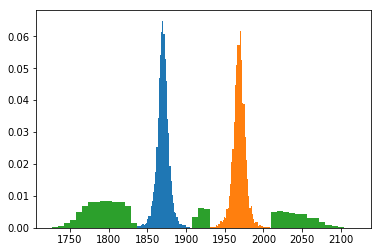

In [4]:

plt.hist(MC_Dplus_sig_dict["Dplus_ConsD_M"],bins=50, density=True);
plt.hist(MC_Ds_sig_dict["Ds_ConsD_M"],bins=50, density=True);
plt.hist(data_bkg_dict["Ds_ConsD_M"],bins=50, density=True);

In [5]:
#Convert data dictionaries to arrays for XG_BOOST
features=return_branches_BDT(mother_index=0, l_index=l_index)
MC_Dplus_sig = extract_array_for_BDT(MC_Dplus_sig_dict, features, m_plus)

features=return_branches_BDT(mother_index=1, l_index=l_index)
MC_Ds_sig = extract_array_for_BDT(MC_Ds_sig_dict, features, m_s)

features=return_branches_BDT(mother_index=1, l_index=l_index)
data_bkg = extract_array_for_BDT(data_bkg_dict, features, n)

In [6]:
dim=len(features)

In [7]:
#Add 0/1 label for bkg/sig

MC_Dplus_sig_labelled=add_labels(MC_Dplus_sig,signal=True)
MC_Ds_sig_labelled=add_labels(MC_Ds_sig,signal=True)
data_bkg_labelled=add_labels(data_bkg,signal=False)

#Merge MC sig and data bkg, shuffle it

data=np.concatenate((data_bkg_labelled,MC_Dplus_sig_labelled), axis =0)
data=np.concatenate((data,MC_Ds_sig_labelled), axis =0)
np.random.seed(1)
np.random.shuffle(data)

#get train size
train_size=data.shape[0]

#Strip away the label column and convert it to a one-hot encoding

X=data[:,0:dim]
Y_labels=data[:,dim].astype(int)
Y_labels=Y_labels.reshape(train_size,1)
Y_labels_hot = to_one_hot(Y_labels)
Y_labels=Y_labels_hot

# Training XGBOOST with K-folding

In [8]:
#Divide the dataset k "equi populated" sets
test=1
k=10 #number of subsets
plot=True
for i in range(k):    
    X_train, Y_train, X_test, Y_test, X_dict, Y_dict = k_subsets(i, k, X, Y_labels)
    
    PATH_BDTs=PATH+'BDT/'+l_flv[l_index]+'/test_'+str(test)
    
    if not os.path.exists(PATH_BDTs):
        os.mkdir(PATH_BDTs)
    
    if not os.path.exists(PATH_BDTs+'/variables_used.pickle'):
        with open(PATH_BDTs+'/variables_used.pickle', 'wb') as handle:  
            pickle.dump(features, handle, protocol=2)
    
    PATH_current_BDT=PATH_BDTs+'/XG_'+str(i)
    
    if not os.path.exists(PATH_current_BDT):
        os.mkdir(PATH_current_BDT)
        
    model = XGBClassifier()
    model.fit(X_train, Y_train[:,1])
    
    output_XG = model.predict_proba(X_test)
    
    if plot:
        
        plt.clf();
        true_positives_XG=output_XG[:,1][np.where(Y_test[:,1]==1)]
        false_positives_XG=output_XG[:,1][np.where(Y_test[:,0]==1)]
        plt.hist(true_positives_XG,alpha=0.5,bins=80,density=True,label="True positives");
        plt.hist(false_positives_XG,alpha=0.5,bins=80,density=True, label="False positives");
        plt.legend()
        plt.xlabel("XGBoost BDT output", fontsize='15')
        plt.ylabel("Events (a.u.)", fontsize='15')
        fig=plt.gcf()
        fig.set_size_inches(16,8)
        plt.savefig(PATH_current_BDT+'/tp_vs_fp_XG.png', format='png', dpi=100)
        plt.clf();
        
        threshold_range=np.linspace(0.0,1.,num=30)
        sig_eps_vals_XG=[sel_eff(true_positives_XG,threshold_range[k]) for k in range(len(threshold_range))]
        bkg_eps_vals_XG=[sel_eff(false_positives_XG,threshold_range[k]) for k in range(len(threshold_range))]
        
        
        plt.plot(threshold_range,threshold_range, 'black', linestyle='dashed')
        plt.plot(bkg_eps_vals_XG,sig_eps_vals_XG,'b',label="XG Boost ROC Curve")
        plt.xlabel("Background selection efficiency", fontsize='15')
        plt.ylabel("Signal selection efficiency", fontsize='15')
        pAUC_XG=roc_auc_score(Y_test,output_XG)
        plt.text(0.69,0.1,"\n XGBoost AUC {0:.4g}\n".format(pAUC_XG), bbox=dict(boxstyle="round", facecolor='blue', alpha=0.10), horizontalalignment='center', verticalalignment='center',fontsize='15')
        plt.legend()
        fig=plt.gcf()
        fig.set_size_inches(8,8)
        
        print("pAUC from XG Boost {0}".format(pAUC_XG))
        plt.savefig(PATH_current_BDT+'/roc_comparison_'+str(i)+'.png', format='png', dpi=100)
        plt.clf();
        
        plt.bar(np.arange(dim),model.feature_importances_)
        plt.xticks(np.arange(dim), features[:-1], rotation=90, fontsize=12);
        fig=plt.gcf()
        fig.set_size_inches(12,6)
        plt.savefig(PATH_current_BDT+'/significant_features_'+str(i)+'.png', format='png', dpi=100)
        plt.clf();
        
    # save XGBOOST model to file
    pickle.dump(model, open(PATH_current_BDT+"/XG_"+str(i)+".pickle.dat", "wb"), protocol=2)

pAUC from XG Boost 0.89248732815
pAUC from XG Boost 0.8981822648
pAUC from XG Boost 0.891673744237
pAUC from XG Boost 0.901611464589
pAUC from XG Boost 0.907353115727
pAUC from XG Boost 0.895278819119
pAUC from XG Boost 0.894574348419
pAUC from XG Boost 0.897631671969
pAUC from XG Boost 0.891227438988
pAUC from XG Boost 0.875042311412


<Figure size 864x432 with 0 Axes>